# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

In [48]:
# Add any additional libraries or submodules below
#import missingno as msno
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from imblearn.over_sampling import SMOTE

# Stats libraries
from scipy.stats import chi2_contingency
# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from scipy.stats import randint
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.metrics import auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, ConfusionMatrixDisplay

In [ ]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")
d.head()

C:\Users\User\AppData\Local\Temp\ipykernel_476\2405334245.py:2: DtypeWarning:

Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.



,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,seller_name,servicer_name,flag_sc,id_loan_rr,program_ind,rr_ind,property_val,io_ind,mi_cancel_ind,loan_status
0,809,201705,N,204704,NaN,0,1,P,75,38,...,Other sellers,SPECIALIZED LOAN SERVICING LLC,NaN,NaN,9,NaN,2,N,7,prepaid
1,702,201703,N,203202,NaN,0,1,P,80,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,active
2,792,201703,N,204702,NaN,0,1,S,60,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
3,776,201703,N,204702,NaN,0,1,S,80,18,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
4,790,201703,N,204702,41620.0,0,1,I,75,42,...,Other sellers,"PNC BANK, NA",NaN,NaN,9,NaN,2,N,7,active


# Introduction

In this report we will demonstrate how we developed a tuned a classification model for the Single Family Loan-Level Dataset, collected by Freddie Mac (from 2017-2020). The dataset includes 32 features ranging from Credit score to loan purpose. Additionally, we have our response variable loan_status, this describes the status of the loan whether they defaulted on the loan, paid the loan, or if the loan is still active. 

As part of our pre-processing, we had to deal with pseudo-NaN values. In the Dataset Details, we were told about the unique NaN values that were reassigned values (eg. `property_val` NaN values are coded as 9). We investigated which features had missing values and implemented appropriate imputation methods to maintain potential relationships, and avoids any bias generated from deleting data. 

Given the nature of loan defaults, the data is highly imbalanced meaning that we have significantly more prepaid or active loans than defaulted loans. From the 200,000 loans, only around 0.37% are defaulted, to combat this we implemented SMOTE oversampling into our process, allowing us to create a more robust model. 

Our model aims to discriminate between prepaid and defaulted mortgages and in the final section we applied the model to active loans to see loans at potential risk of defaulting. We first developed an intuitive baseline model using Logistic Regression, this formed a basis for our final model using a Random Forest Classifier. Both models used similar features to classify loans, the most important being `fico`, `cnt_borr` and `prod_type`. And we explore how these features are considered by our model using SHAP values. 

Finally, we will use our final model to assess active loans that could be at risk of being defaulted in the future. This risk analysis will take into account the model’s prediction as well as our observations on each loan’s main statistics.

# Exploratory Data Analysis and Feature Engineering

**Initial Test-Train Split**

We first make an initial test-train split of our data with 80% for training and 20% for testing. We also store the active loans in order to conduct some risk analysis of active loans using our model. Given the nature of loan defaults our data is extremely imbalanced, for this reason when splitting our data into test and training sets, we stratify our split to ensure both sets have an equal proportion of prepaid and defaulted loans. Doing so, both sets have a default rate of around 0.006. Later in this report we will be investigating active loans at potential risk of defaulting, so we will store these active loans in a new data set `active_loans`. 

In [52]:
# Storing active loans to use later
active_loans = d[d['loan_status'] == 'active'].copy()
y_active = active_loans['loan_status']     
X_active = active_loans.drop(columns='loan_status')
# Filter out loans that are still being repaid, keeping only prepaid and defaulted samples
d = d[d['loan_status'] != 'active'].copy()
# Add a new label column: default = 1, prepaid = 0
d['default_flag'] = (d['loan_status'] == 'default').astype(int)
# Drop the 'loan_status'
d.drop(columns=['loan_status'], inplace=True)
# Split the data into training and testing sets (stratified by default label)
X = d.drop(columns=['default_flag'])
y = d['default_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
training = pd.concat([X_train, y_train], axis=1)

In [53]:
# Load the zip code mapping file
zip_df = pd.read_excel("uszips.xlsx")
# Convert to string
zip_df["zipcode"] = zip_df["zip"].astype(str).str.zfill(5)
# Extract first three digits from padded zip code
zip_df["zip_prefix"] = zip_df["zipcode"].str[:3]
# Drop duplicates so that each three-digit prefix maps uniquely to a state.
zip_mapping_df = zip_df.drop_duplicates(subset=["zip_prefix"])[["zip_prefix", "state_id"]]
def transform_default_zip(zip_code):
    """
    Transform the zip code to a three-digit prefix.
    """
    zip_code = str(zip_code)
    # Remove trailing "00" if present
    if zip_code.endswith("00"):
        zip_code = zip_code[:-2]
    # Return the first three characters if available
    return zip_code[:3] if len(zip_code) >= 3 else zip_code

df = training.copy()

# Ensure the zipcode column is a string and apply the transformation to create a three-digit prefix
df["zipcode"] = df["zipcode"].astype(str)
df["zip_prefix"] = df["zipcode"].apply(transform_default_zip)

# Merge the zip code mapping with the training data
df = df.merge(zip_mapping_df, on="zip_prefix", how="left")

# Calculate percentage of defaulted loans by state
state_summary = df.groupby("state_id", as_index=False).agg(
    total_defaults=('default_flag', 'sum'),  # Total defaults
    total_count=('default_flag', 'count')   # Total records
)
state_summary["default_rate"] = (state_summary["total_defaults"] / state_summary["total_count"]) * 100

# Using Plotly Express to create a choropleth map
fig = px.choropleth(
    state_summary,
    locations="state_id",              # Column with state abbreviations in uszips.xlsx
    locationmode="USA-states",         
    color="default_rate",
    scope="usa",
    color_continuous_scale="Reds",
    labels={"default_rate": "Default Rate (%)"},
    title="Percentage of Defaulted Mortgages by State"
    )
fig.show()

Investigating the default rates across the states, we see that we have ranges between 0 and around 1.4%. In A Spatio-Temporal Machine Learning Model for Mortgage Credit Risk: Default Probabilities and Loan Portfolios, Kundig et al. uses the longitude and latitude of the first three digits of the loan’s zip code [2]. This allows them to use special data over 20 years to make a classifier model to account for long term fluctuations in the market for each region. Given our data is from 2017-2020, long term changes in the market won’t be as prevalent. Differences in default rates between states can be observed, suggesting this is an important factor to consider when classifying loans. These observed differences could be a result of the micro economy of states. We find Louisiana to have the highest default rate in our data, this could be a result of two devastating storms (hurricane Laura and Zeta) in 2020 on top of the Covid-19 pandemic.

**Add new features**

In [40]:
# Add a new feature 'is_harp_loan' to indicate if a loan is a HARP l
d['is_harp_loan'] = ((d['rr_ind'] == 'Y') & (d['ltv'] > 80)).astype('object')

# Add a new feature 'msa' to indicate if loan is in MSA or MD
d['msa'] = d['cd_msa'].notnull().astype('object')

# Add a new feature 'Nat_A' to indicate where the loan belong
d['zipcode'] = d['zipcode'].astype(str)

# Add a new feature for the national area code
d['Nat_A'] = d['zipcode'].apply(lambda x: '0' if len(x) < 5 else x[0]).astype('object')

In the dataset description harp loans were mentioned, these are loans which are both a Relief Refinance and have an Original Loan-to-Value ratio over 80. Adding this additional feature will aim to reduce the false negatives (classifying as default when actually prepaid) in our model. We found that current literature on mortgage loan classifiers prefer to use whether a loan is from a Metropolitan Statistical Area (MSA)/ Metropolitan Division (MD) or not. For this reason, we converted the MSA/ MD codes `cd_msa` to a binary variable `msa`. Finally, using findings in our EDA and from current literature, we found that region plays a role in default rates. To avoid overfitting, we used the national code from the zip code (the first digit) as an indicator of the loan’s location.

**Removeing irrelevant features**:

Whilst conducting our EDA we found some features were not contributing any significance to our research. Some features are the same value for all loans and for this reason we removed them from our working data set. Additionally, to avoid multicollinearity and relationships with the new features we added, we removed the old features. Finally, the `servicer_name` and `seller_name` have been found to be not significant for this classification model. For this reason, they were also dropped from the data set helping reduce the number of features we are working with.

`id_loan`: change to index

`prod_type`: constantly "FRM" throughout the dataset and shows no variation, drop

`ppmt_pnlty`: consistently "N", no information gain, drop

`io_ind`: consistently "N", no information gain, drop

`dt_matr`: can be derived from the `dt_first_pi` and `orig_loan_term` and are of limited predictive value, drop (explain why keep `dt_first_pi`)

`id_loan_rr`and `rr_ind`: relate to loan refinancing/ have multicollinearity, drop

`servicer_name` and `seller_name`: drop, (by references)

`cd_msa` and `zipcode`: create the new features which summary these features (by references)

In [41]:
# Replace Index with id_loan
d = d.set_index('id_loan')

# Remove irrelevant features
drop_cols = ['prod_type', 'ppmt_pnlty', 'io_ind', 'id_loan_rr','rr_ind','dt_matr','cd_msa','zipcode', 'seller_name','servicer_name']
d.drop(columns=[c for c in drop_cols if c in d.columns], inplace=True)

**Handling NaN Values and Pseudo-NaN Values**:

As mentioned in the introduction, we were told of pseudo-NaN values coded into our data set. To ensure we handle these correctly we implemented the following conversion. This allows us to appropriately conduct the EDA and address missingness in our features. 

Numerical:

`fico`: typically ranges from 300 to 850, but a value of 9999 indicates not available

`mi_pct`, `cltv`, `dti` and `ltv`: a value of 999 indicates not available

`property_val`: a value of 9 indicates not available

Categorical:

`flag_sc`: 'NaN' indicates NaN

`program_ind`: '9' indicates NaN

`mi_cancel_ind`:  '7' and '9' indicate NaN

In [42]:
# Replace pseudo-missing numeric codes with NaN
d.replace({'fico': {9999: np.nan}, 'mi_pct': {999: np.nan}, 'cltv': {999: np.nan}, 'dti': {999: np.nan},
           'ltv': {999: np.nan}, 'cnt_units': {99: np.nan}, 'property_val': {9: 'N'}}, inplace=True)
# Replace categorical pseudo-missing codes with consistent label
d['flag_sc'] = d['flag_sc'].fillna('N')
d['program_ind'] = d['program_ind'].replace('9', np.nan)
d['program_ind'] = d['program_ind'].fillna('N')
d['mi_cancel_ind'] = d['mi_cancel_ind'].replace('7', np.nan)
d['mi_cancel_ind'] = d['mi_cancel_ind'].fillna('N')
# Convert dt_first_pi, cnt_units, cnt_borr, property_val column to object class since it is categorical
d['dt_first_pi'] = d['dt_first_pi'].rank(method='dense').astype('object')
d['property_val'] = d['property_val'].astype('object')
d['cnt_borr'] = d['cnt_borr'].apply(lambda x: 'single' if x == 1 else 'multiple')

To handle pseudo-NaN values, we apply different strategies based on variable type. For numerical features, special codes such as 999 or 9999 are replaced with NaN, since these values do not carry valid quantitative meaning and should be treated as true missing data. This allows for appropriate downstream handling, such as imputation or row exclusion, and prevents misleading the model with extreme or invalid values.

In contrast, for categorical features, pseudo-NaN codes like '9' or '7' are replaced with a consistent label 'N', representing “Not Available.” This preserves the categorical structure of the data while allowing the model to treat missingness as a distinct, learnable category.

In [43]:
# Split the data into training and testing sets (stratified by default label)
X = d.drop(columns=['default_flag'])
y = d['default_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
training = pd.concat([X_train, y_train], axis=1)

print("Training set size:", X_train.shape, "Default rate:", y_train.mean())
print("Test set size:", X_test.shape, "Default rate:", y_test.mean())

Training set size: (101364, 24) Default rate: 0.0058896649698117675
Test set size: (25341, 24) Default rate: 0.0058797995343514466


Given we have adjusted the features and corrected missing data, we will reconstruct our test-train spit using the same stratified method as before.

In [44]:
# Create a list of categorical columns
categorical_features = d.select_dtypes(include=['object']).columns.tolist()
print(categorical_features)

# Create a list of numerical columns
numerical_features = d.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_features)

['dt_first_pi', 'flag_fthb', 'occpy_sts', 'channel', 'st', 'prop_type', 'loan_purpose', 'cnt_borr', 'flag_sc', 'program_ind', 'property_val', 'mi_cancel_ind', 'is_harp_loan', 'msa', 'Nat_A']
['fico', 'mi_pct', 'cnt_units', 'cltv', 'dti', 'orig_upb', 'ltv', 'int_rt', 'orig_loan_term']


Above we have provided a list of the features we will be using for the rest of our analysis; to reduce overfitting it is important to remove unnecessary features. We will be addressing this in our feature selection phase but before then we will conduct some exploratory data analysis to gain some basic insights into our data.

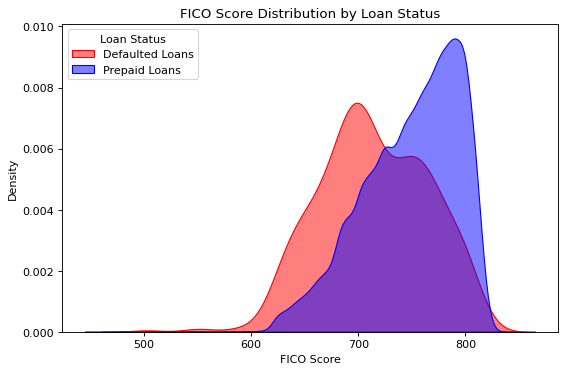

In [45]:
# Filter the data into two groups: defaulted and prepaid
defaulted_loans = training[training['default_flag'] == 1]['fico']
prepaid_loans = training[training['default_flag'] == 0]['fico']
# Plot the distributions using KDE (Kernel Density Estimate)
sns.kdeplot(defaulted_loans, label='Defaulted Loans', color='red', fill=True, alpha=0.5, common_norm=False)
sns.kdeplot(prepaid_loans, label='Prepaid Loans', color='blue', fill=True, alpha=0.5, common_norm=False)
# Add labels and title
plt.title('FICO Score Distribution by Loan Status')
plt.xlabel('FICO Score')
plt.ylabel('Density')
plt.legend(title='Loan Status', fontsize=10)
plt.show()

Above we have the distribution of credit scores, coloured by whether they are prepaid or defaulted. We find the prepaid loans have a negative skew, this can partially be explained by the way `fico` is coded, as credit score above 850 are shown as not available. For defaulted loans, we see a more normal distribution around 700, this is noticeably lower than the mean for prepaid loans. This aligns with current literature, as a majority of studies use credit score in their classification model [1, 2, 3]. Above we have the distribution of credit scores, coloured by whether they are prepaid or defaulted. We find the prepaid loans have a negative skew, this can partially be explained by the way `fico` is coded, as credit score above 850 are shown as not available. For defaulted loans, we see a more normal distribution around 700, this is noticeably lower than the mean for prepaid loans. This aligns with current literature, as a majority of studies use credit score in their classification model [1, 2, 3]. 

Text(0, 0.5, 'DTI')

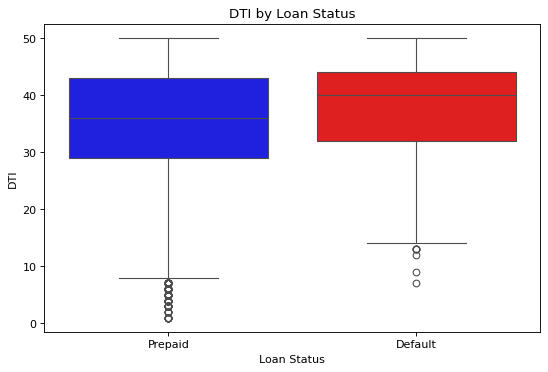

In [46]:
sns.boxplot(x='default_flag', y='dti', data=d, palette={'0': 'blue', '1': 'red'})
plt.xticks([0, 1], ['Prepaid', 'Default'])
plt.title('DTI by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('DTI')

Another commonly used feature in loan classification is the Debt-to-Income ratio, investigating how `dti` differs between prepaid and defaulted loans, we see that the mean `dti` of defaulted loans is around 5 more than prepaid loans, Additionally, only outliers from defaulted loans have a `dti` lower than 15. This intuitively makes sense, given if an individual has a high debt-to-income ratio, they will have to use their income to pay for other loans putting more risk of defaulting on their mortgage. 

In [50]:
# Filter data for 'prepaid' and 'default' loan statuses
filtered_data = training[training['default_flag'].isin([0, 1])]
# Group by 'msa' and 'default_flag' to create a contingency table
msa_loan_status = filtered_data.groupby(['msa', 'default_flag']).size().unstack(fill_value=0)
# Perform a chi-square test of independence
chi2, p, dof, expected = chi2_contingency(msa_loan_status)
print(f"P-value: {p:.4f}")

P-value: 0.0000


The above code conducts a Chi-squared test on the relationship between `msa` and the loans status. We find the `msa` is statistically significant with a p-value less than 0.01. What this doesn’t tell us is how `msa` interacts with the loan’s status, loans from an MSA will have a higher and usually denser population, this could both improve individual’s income however it could be a sign of high living costs, increasing the risk of individuals defaulting on their mortgage.   

**Missing data check**

In [38]:
numerical_features = [col for col in numerical_features if col in X_train.columns]
missing_counts = X_train[numerical_features].isnull().sum()
missing_percent = (missing_counts / len(X_train)) * 100
print(missing_percent[missing_percent > 0])

fico    0.019731
cltv    0.000987
dti     1.019099
ltv     0.000987
dtype: float64


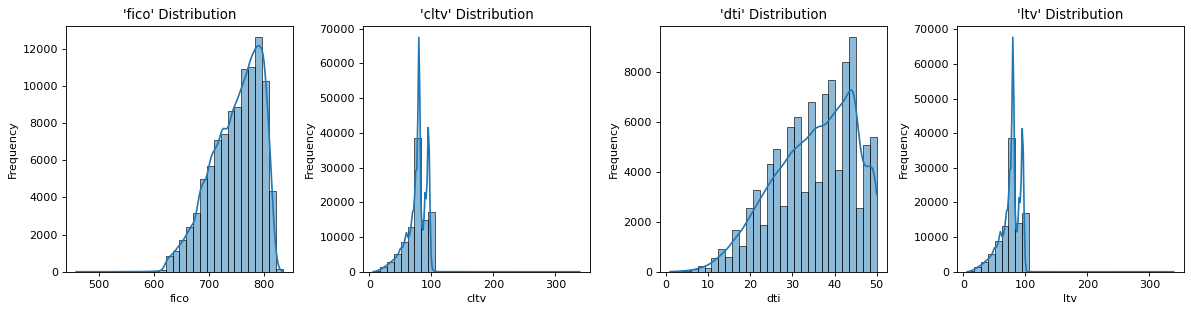

In [39]:
# Select numeric columns
numeric_missing = ['fico', 'cltv', 'dti', 'ltv']
# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 4)) 
for i, col in enumerate(numeric_missing):
    sns.histplot(X_train[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"'{col}' Distribution")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

Given all four of the numerical features with missing values are skewed, we will implement median imputation in our preprocessing pipeline to best replace these missing values. 

**Investigating Relationships**

<Axes: >

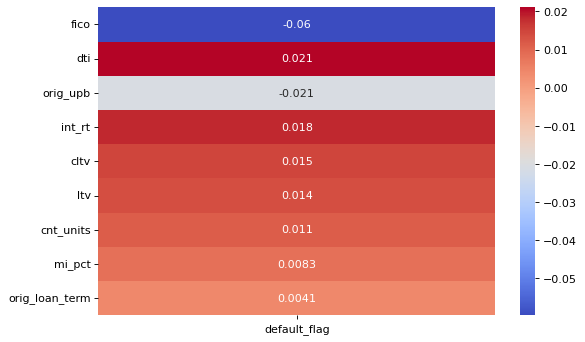

In [40]:
corr_matrix = pd.concat([X_train, y_train], axis=1).corr(numeric_only=True)
target_corr = corr_matrix[['default_flag']].drop('default_flag').sort_values(by='default_flag', key=abs, ascending=False)
sns.heatmap(target_corr, annot=True, cmap='coolwarm')

The correlation heatmap shows that all numerical features have very weak linear relationships with the target variable default_flag. This is likely due to the highly imbalanced nature of the dataset, where the proportion of default cases is extremely low. In such settings, traditional correlation metrics tend to understate the predictive value of features, as the minority class is underrepresented in the statistical estimation. To address this, we apply SMOTE (Synthetic Minority Over-sampling Technique) to rebalance the dataset by generating synthetic default samples. This improves the model’s ability to learn patterns associated with the rare class and enhances performance on imbalanced classification tasks.

**3.5 Data Transformations**

Later in this report we will be applying a range of models to best classify loans. To ensure the data is suitable for all the models, it is essential that we standardise our numerical features. This gives us the best chance to remove any bias in the scale of features. We implement this into our pipeline through our preprocessing pipelines. 

**3.6 Feature Engineering**

In order to appropriately consider our categorical features in our model, we implement one-hot-encoding. This allows us to model for individual categories within a feature. One major downside to this approach is that it dramatically increases our feature space. To ensure this doesn’t become an issue later, we will conduct tests in order to select only important features. Similar to “Investigating bankruptcy prediction models in the presence of extreme class imbalance and multiple stages of economy” [2], we will be using Random Forest to determine the importance of features. This has its drawbacks as a more considerate method could be implemented to obtain better results.

# Model Fitting and Tuning
**4.1 Pipeline and Oversampling**

In [42]:
# Create lists for imputation types (specific columns to impute with the median)
median_impute = ['fico', 'cltv', 'dti', 'ltv', 'mi_pct']
# Numerical imputer pipeline: 
numerical_transformer = Pipeline([
    ('impute', ColumnTransformer([
    ("median_impute", SimpleImputer(strategy='median'), median_impute)
], remainder='passthrough')),
    ('scaler', StandardScaler())])
# Categorical transformer pipeline:
categorical_transformer = Pipeline([
    ('to_str', FunctionTransformer(lambda x: x.astype(str))),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# Column transformer: 
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)])
# Fit the preprocessor on the training data and transform the training set.
X_train_enc = preprocessor.fit_transform(X_train)
# Transform the test set and any other active data.
X_test_enc = preprocessor.transform(X_test)
X_active_enc = preprocessor.transform(X_active)

After encoding, the dimensionality of the training feature matrix increases significantly from 24 to 158 due to the one-hot encoding of categorical variables. The pipeline ensures that the same transformations are consistently applied to both the training and testing data.

Before training the model, it is necessary to address the issue of an underrepresented number of default samples. We applied the SMOTE algorithm to oversample the positive class in the training set, increasing the number of default samples to be comparable to the prepaid samples, thereby balancing the training data.

In [43]:
# Apply SMOTE to oversample the training set
smote = SMOTE(random_state=0)
X_train_res, y_train_res = smote.fit_resample(X_train_enc, y_train)

After oversampling, the number of training samples increases significantly, with default and prepaid cases each accounting for 50%. This balanced distribution provides the model with sufficient default cases to learn from, helping to alleviate the issue of the model being biased toward predicting the majority class.

After applying one-hot encoding, we observed that the number of feature variables increased from 24 to 158, which posed significant challenges for subsequent modeling. To address this, through reference, we employed a two-step feature selection method. First, we used the Filter method (SelectKBest) to select the top 50 features most relevant to the target variable, evaluating their importance based on the ANOVA F-value. Second, we applied the Random Forest method to further refine the features, selecting those with an importance score higher than the median in the Random Forest model. This process resulted in retaining the most important features, including `fico`, `mi_pct`, `cnt_units`, `cltv`, `dti`, `ltv`, `int_rt`, `dt_first_pi_11.0`, `flag_fthb_N`, `flag_fthb_Y`, `channel_R`, `st_FL`, `prop_type_PU`, `prop_type_SF`, `loan_purpose_C`, `cnt_borr_multiple`, `cnt_borr_single`, `property_val_1`, `property_val_3`, `msa_False`, `Nat_A_0`, `Nat_A_2`, `Nat_A_3`, `Nat_A_5`, `Nat_A_8`, thereby reducing the feature dimensionality and improving the efficiency of model training.

In [44]:
# Step1: Filter-based feature selection
filter_selector = SelectKBest(score_func=f_classif, k=50)
filter_selector.fit(X_train_res, y_train_res)
X_train_res_filter = filter_selector.transform(X_train_res)
# Step2: Random Forest feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train_res_filter, y_train_res)
model_selector = SelectFromModel(rf, prefit=True, threshold="median")
X_train_final = model_selector.transform(X_train_res_filter)

In [48]:
# Define numeric features and get one-hot encoded categorical feature names
numeric_features = numerical_features
onehot = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = onehot.get_feature_names_out(categorical_features)
feature_names_encoded = np.concatenate([numeric_features, categorical_feature_names])
filter_support = filter_selector.get_support(indices=True) # Step1 selection
rf_support = model_selector.get_support(indices=True) # Step2 selection based on Step1
final_feature_indices = filter_support[rf_support]
final_feature_names = feature_names_encoded[final_feature_indices] # Final feature selection
X_test_final = X_test_enc[:, final_feature_indices]
X_active_final = X_active_enc[:, final_feature_indices]

**4.2 Baseline Model: Logistic Model**

We selected Logistic Regression as the baseline model and evaluated its performance using 5-fold cross-validation. The model handles the class imbalance issue by using class_weight='balanced' and sets the maximum number of iterations to 1000 to ensure adequate training. The evaluation results show that the model achieves an accuracy of 0.715, precision of 0.709, recall of 0.730, F1 score of 0.719, and AUC of 0.782, indicating a balanced performance in distinguishing between prepaid and defaulted loans. However, by examining the confusion matrix, we observed a relatively high number of false positives (FP), suggesting that Logistic Regression may not handle the prediction task between the two classes effectively. Nevertheless, this model serves as a reference for the selection and performance improvement of subsequent models.

In [49]:
# Use StratifiedKFold for 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Define Logistic Regression model with balanced class weights
logistic = Pipeline([
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))])
# Perform cross-validation to get predicted class labels and probabilities
y_pred_cv = cross_val_predict(logistic, X_train_final, y_train_res, cv=cv)
y_prob_cv = cross_val_predict(logistic, X_train_final, y_train_res, cv=cv, method='predict_proba')[:, 1]
# Compute the confusion matrix for predicted vs actual labels
confusion_matrix(y_train_res, y_pred_cv)

array([[70579, 30188],
       [27222, 73545]])

**4.3 Model Training**

We trained and evaluated four classification models using Stratified K-Fold (5-fold) cross-validation for performance assessment. The models included:
1. Support Vector Machine: This model is capable of capturing non-linear decision boundaries in the feature space.
2. Decision Tree: A model that performs non-linear splits but is prone to overfitting if not pruned properly.
3. Random Forest: An ensemble of decision trees that enhances generalization and mitigates overfitting.
4. K-Nearest Neighbors: A non-parametric model that classifies a sample based on the majority class of its neighbors.

The models are evaluated based on their performance in terms of accuracy, precision, recall, F1-score, and AUC.

- SVM: Achieved an accuracy of 0.858, with a precision of 0.832, recall of 0.898, F1-score of 0.864, and AUC of 0.936.
- Decision Tree: Achieved an accuracy of 0.989, with a precision of 0.986, recall of 0.992, F1-score of 0.989, and AUC of 0.989.
- Random Forest: Achieved an accuracy of 0.997, with precision of 0.999, recall of 0.995, F1-score of 0.997, and AUC of 1.000.
- KNN: Achieved an accuracy of 0.973, precision of 0.949, recall of 1.000, F1-score of 0.974, and AUC of 0.991.

Although all models achieved high accuracy, this metric alone can be misleading in the context of imbalanced classification. Therefore, we placed greater emphasis on more informative metrics such as precision, recall, F1-score, and ROC AUC. For the SVM model, while capable of capturing non-linear boundaries, exhibited only moderate precision (0.832) and required substantial computational resources due to the dataset size, making it impractical for further tuning. For the Decision Tree model showed performance comparable to Random Forest, but it is more prone to overfitting and lacks the generalization ability of ensemble methods. For the KNN model achieved a perfect recall of 1.000, but it demands large memory, suffers from slow prediction speed, and is sensitive to noise, which limits its scalability.

In contrast, Random Forest consistently outperformed all other models across metrics. These indicate its superior capability in distinguishing defaulted from non-defaulted loans. Notably, Random Forest also significantly outperformed the baseline Logistic Regression model, which justifies the use of more complex models and appropriate imbalance-handling strategies. Given its robustness, scalability, and excellent cross-validation performance, we selected Random Forest as the final model for further tuning and deployment.

In [50]:
# Use StratifiedKFold for 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Define Random Forest model with balanced class weights
rf = Pipeline([
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))])
# Perform cross-validation to get predicted class labels and probabilities
y_pred_cv = cross_val_predict(rf, X_train_final, y_train_res, cv=cv)
y_prob_cv = cross_val_predict(rf, X_train_final, y_train_res, cv=cv, method='predict_proba')[:, 1]
# Compute the confusion matrix for predicted vs actual labels
confusion_matrix(y_train_res, y_pred_cv)

array([[100694,     73],
       [   511, 100256]])

**4.4 Hyperparameter Tuning of the Selected Model**

Having chosen Random Forest as our best-performing model, we performed hyperparameter tuning using RandomizedSearchCV (with 5-fold cross-validation on the training set) to further improve its performance by compare the metric of 'F1-score'. We experimented with the following hyperparameters: `Number of Trees`, `Tree Depth`, `Minimum Samples Split and per Leaf`.

The best combination of parameters identified was: `n_estimators=142`, `max_depth=None`, `min_samples_split=9`, and `min_samples_leaf=1`. This configuration achieved a best F1 score of approximately 0.9788, indicating a substantial performance gain over the baseline model. These results suggest that fully grown trees and fine-grained node splitting contributed to the model’s enhanced ability to distinguish defaults from non-defaults. The final model was then retrained on the full training set using these optimized parameters.

In [54]:
X_sample, y_sample = resample(X_train_final, y_train_res, n_samples=20000, random_state=42, stratify=y_train_res)
# Define the hyperparameter distribution for RandomizedSearchCV
param_dist = {'clf__n_estimators': randint(80, 151),
    'clf__max_depth': [None, 5, 10, 15, 20],
    'clf__min_samples_split': randint(2, 11),
    'clf__min_samples_leaf': randint(1, 6)}
# Set up RandomizedSearchCV with cross-validation, scoring by F1
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=30, cv=cv,
    scoring='f1', random_state=42, n_jobs=-1, verbose=1)
random_search.fit(X_sample, y_sample) # Fit the model to the resampled data
best_rf_final = random_search.best_estimator_ # Get the best model

Fitting 5 folds for each of 30 candidates, totalling 150 fits


**4.5 Final Model Evaluation**

After fine-tuning the Random Forest model, we achieved excellent results across multiple evaluation metrics, with a precision of 0.999, recall of 0.994, F1-score of 0.997, and AUC of 1.000. The confusion matrix further illustrates that the model correctly classified 100,766 non-default loans and 100,471 defaulted loans. Additionally, false positives decreased from 73 to 1, and false negatives reduced from 511 to 296, indicating that the fine-tuned model performs well in target classification.

In [55]:
# Fit the best Random Forest model to the entire training data
best_rf_final.fit(X_train_final, y_train_res)
# Evaluate the model using 5-fold cross-validation on multiple metrics
cv_results = cross_validate(best_rf_final, X_train_final, y_train_res, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
y_pred_cv = best_rf_final.predict(X_train_final) # Predict class labels for the training data
# Compute the confusion matrix for predicted vs actual labels
confusion_matrix(y_train_res, y_pred_cv)

array([[100766,      1],
       [   296, 100471]])

After applying SHAP to interpret the feature influences in our Random Forest model, we identified several critical features driving the likelihood of loan default. Property Type was found to have the most significant impact, with single-family homes (SF) showing a higher risk of default compared to Planned Unit Developments (PU). This suggests that certain property types, potentially influenced by socio-economic factors or specific loan terms, are more likely to result in defaults. Similarly, Credit Score (`fico`) had a strong influence on default risk, as lower credit scores were strongly associated with higher chances of default, while higher scores reduced the risk, which aligns with expectations about creditworthiness.

Additionly, Number of Borrowers (`cnt_borr`) also played a significant role in the default prediction. Whether the loan had one or multiple borrowers, the SHAP analysis showed that a higher number of borrowers correlated with a higher default probability. Furthermore, Channel of Loan Origination (`channel_R`) demonstrated that loans originated through retail channels had a higher risk of default. Loan-to-Value (`ltv`) and Interest Rate (`int_rt`) were also important features, with higher LTV ratios and interest rates both contributing to an increased likelihood of default, highlighting that these factors often correlate with higher-risk loans.

To further validate these findings, we examined the feature importance rankings from the Random Forest model based on Gini impurity reduction. The top-ranked features, including `fico`, `cnt_borr`, and `prop_type`, confirmed the results from the SHAP analysis, with `fico` and `cnt_borr` standing out as key predictors. The importance of `int_rt` further supports the notion that higher interest rates are a strong indicator of credit risk. Although state-level dummies had lower importance, they did suggest that geographic location may influence the likelihood of loan default, indicating that regional factors could play a role in default prediction, albeit to a lesser extent.

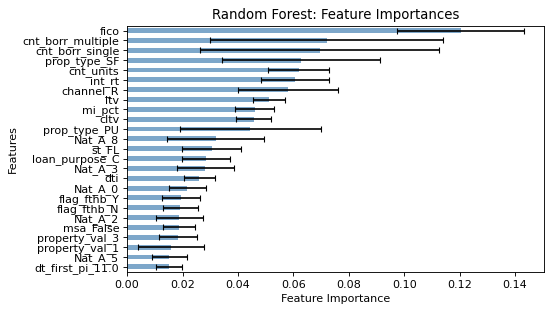

In [56]:
# Extract the actual Random Forest model from the pipeline
rf_model = best_rf_final.named_steps['clf']
# Calculate the standard deviation of feature importances for each tree
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
# Create a DataFrame with feature importances and their standard deviations
df_features = pd.DataFrame({'importance': rf_model.feature_importances_,'std': std}, index=final_feature_names)
df_features.sort_values('importance', ascending=True, inplace=True) # Sort the features by importance
# Plot horizontal bar chart
importances_rf = df_features['importance']
std_sorted = df_features['std']
ax = importances_rf.plot.barh(xerr=std_sorted, color='steelblue', alpha=0.7, capsize=3, figsize=(7, 4))
ax.set_title("Random Forest: Feature Importances")
ax.set_xlabel("Feature Importance")
ax.set_ylabel("Features")
plt.tight_layout()
plt.show()

100%|===================| 39996/40000 [61:19<00:00]        


=== SHAP for Default ===


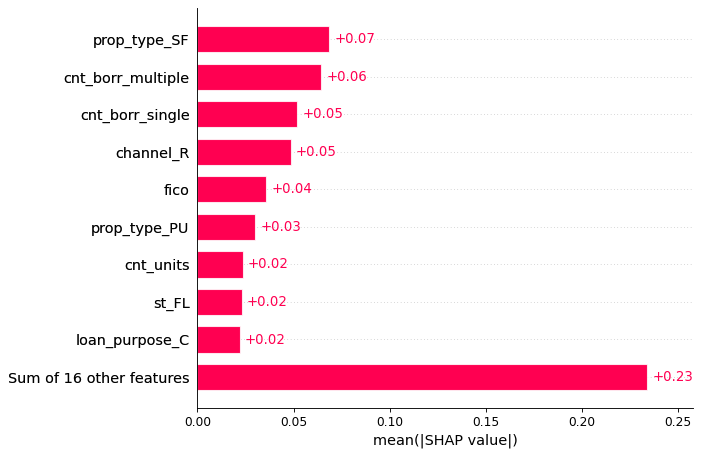

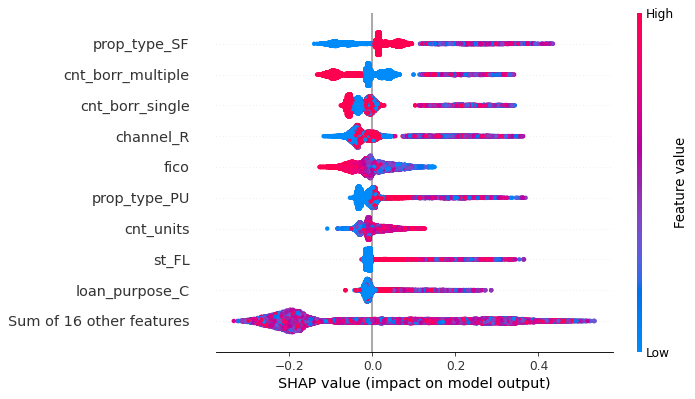

In [58]:
X_sample_dense = X_sample.toarray() # Convert sparse matrix to dense for sampling
# Create SHAP Explainer for the tree model
explainer = shap.Explainer(rf_model, X_sample_dense, feature_names=final_feature_names)
shap_values = explainer(X_sample_dense) # Calculate SHAP values
print(f"\n=== SHAP for Default ===") # Print SHAP values for the positive class (class 1)
shap_values_class = shap_values[..., 1]
# Plot bar chart showing average absolute feature impact
shap.plots.bar(shap_values_class, max_display=10)
# Plot beeswarm chart showing feature distribution across samples
shap.plots.beeswarm(shap_values_class, max_display=10)
plt.show()

**4.6 Testing the Best Random Forest Model**

We validated the Random Forest model using the initially reserved test set. The Logistic Regression model achieved an accuracy of 0.702, precision of 0.014, recall of 0.705, and an F1-score of 0.027. These results suggest that while the model correctly identifies non-defaults, its performance on the minority class (defaults) is significantly poor. The confusion matrix highlights this imbalance, showing that the model fails to correctly identify a large portion of false positives, which is crucial for predicting loan defaults. In contrast, the best-tuned Random Forest model performs much better. This model achieved an accuracy of 0.962, precision of 0.0245, recall of 0.1409, and an F1-score of 0.0417. Although the precision is still low, the F1-score is more than twice that of the Logistic Regression model, indicating its superior ability to detect default loans. The Random Forest model’s ROC curve shows clear improvement with an AUC of 0.700, marking significant progress compared to the baseline Logistic Regression model. Moreover, the confusion matrix of the Random Forest model shows a significant reduction in the number of false positives compared to the Logistic Regression model, demonstrating better performance. However, the relatively low F1-score still indicates room for further improvement in balancing precision and recall.

In [59]:
# Train the logistic regression model on the training data
logistic.fit(X_train_final, y_train_res)
# Make predictions on the test data
y_pred_test = logistic.predict(X_test_final)
y_prob_test = logistic.predict_proba(X_test_final)[:, 1]
# Generate classification report and confusion matrix
classification_report(y_test, y_pred_test)
confusion_matrix(y_test, y_pred_test)

array([[17690,  7502],
       [   44,   105]])

[[24344   848]
 [  128    21]]


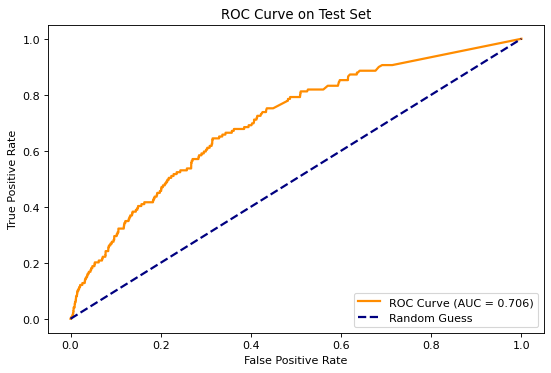

In [61]:
# Make predictions on the test data
y_prob_test = best_rf_final.predict_proba(X_test_final)[:, 1]
y_pred_new = (y_prob_test >= 0.1).astype(int)
# Generate classification report and confusion matrix
classification_report(y_test, y_pred_new)
print(confusion_matrix(y_test, y_pred_new))
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test) # Compute ROC curve and AUC
roc_auc = roc_auc_score(y_test, y_prob_test)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Test Set')
plt.legend(loc="lower right")
plt.show()

# Discussion & Conclusions

**General Overview of Final Model**

Our final model employs a Random Forest classifier to predict mortgage loan defaults, with the parameters `n_estimators=142`, `max_depth=None`, `min_samples_split=9`, and `min_samples_leaf=1`. The target variable, loan_status, is used to predict whether a loan will default or not. The model primarily retains features such as credit score, number of borrowers, and property type, indicating that the borrower's personal information is the most crucial predictor for loan default. The model also includes features like loan-to-value ratio, interest rate, and channel, which, although having relatively smaller influences, still contribute to the prediction. Additionally, we applied SHAP to interpret the model’s decision-making process, which confirmed a high degree of consistency with the Random Forest results. This approach significantly reduced the number of predictive factors, improving the model's interpretability while preserving most of its predictive power.

**Performance and Reliability**

The performance of the Random Forest model was evaluated using several metrics, including accuracy, precision, recall, F1-score, and ROC-AUC. The model achieved an accuracy of 96.2% and an AUC of 0.706 on the test set, demonstrating significant improvement over the baseline Logistic Regression model. The confusion matrix revealed that the Random Forest model correctly classified a higher proportion of non-default loans and significantly reduced false positives, making it a more reliable tool for distinguishing between defaulted and non-defaulted loans. Although the precision remains relatively low at 0.0245, the F1-score of 0.0417 indicates that the model is better at detecting default loans compared to the Logistic Regression model. However, while the model shows reliable performance, there is still room for improvement, especially in handling the minority class (defaults).

**Potential Limitations**

Despite the strong performance of the Random Forest model, there are notable limitations. The F1-socre remains low, indicating that the model may not always correctly identify defaults, which could be problematic for a financial institution looking to minimize risk. Additionally, while SHAP helps interpret feature influences, the inherent complexity of Random Forests limits their interpretability compared to simpler models like Logistic Regression. Fully understanding the interactions between features remains challenging.

**Recommendations on Factors**

Based on the model’s insights, we recommend focusing on the following factors that may increase the risk of mortgage defaults: 
1. Credit Score (`fico`): Loans with lower credit scores are more likely to default. Financial institutions should consider strengthening their criteria for lending to borrowers with poor credit histories, possibly by offering them additional guidance or higher interest rates.
2. Number of Borrowers (`cnt_borr`): Loans with more than one borrower tend to have a higher risk of default. Banks should evaluate the financial stability of all borrowers involved in a loan, as joint borrowers may introduce additional complexities in repayment.
3. Property Type (`prop_type`): Certain property types, such as single-family homes (SF), show a higher risk of default compared to others. Understanding the specific risks associated with different property types can help banks make more informed lending decisions.

As demonstrated by the code below, we can predict that two currently active loans, F17Q20209919 and F19Q20327777, have default probabilities of 91.1% and 88.4%, respectively. Upon examining the features of these loans, we found that both have relatively low credit scores and their Property Type is classified as single-family homes (SF), which, according to our model, is strongly associated with a higher risk of default. These findings suggest that both loans should be closely monitored by the company, as they are at significant risk of default in the near future.

In [63]:
# Predict probabilities of default for active loans
y_prob_active = best_rf_final.predict_proba(X_active_final)[:, 1]
y_pred_active = (y_prob_active >= 0.8).astype(int) # Set a threshold 
# Display the active loans with predicted probabilities and labels
active_loans_with_predictions = X_active.copy()
active_loans_with_predictions['default_probability'] = y_prob_active
active_loans_with_predictions['predicted_default'] = y_pred_active
active_loans_with_predictions = active_loans_with_predictions[['default_probability', 'predicted_default']]
# Display the top loans
high_risk_loans = active_loans_with_predictions.sort_values(by='default_probability', ascending=False).head(4)
print(high_risk_loans)

              default_probability  predicted_default
id_loan                                             
F17Q20209919             0.911389                  1
F19Q20327777             0.884089                  1
F18Q10089196             0.788847                  0
F19Q30135809             0.779429                  0


**Conclusion**

The Random Forest model is a powerful and reliable tool for predicting mortgage defaults, with key features like credit score, the number of borrowers, and property type playing significant roles in predictions. However, there is still room for improvement, particularly in balancing precision and recall to reduce false positives. The model can be further enhanced by adding more features and adjusting its configuration. Its implementation enables financial institutions to better assess and mitigate risk by identifying high-risk loans, helping lenders make more informed decisions and improve financial stability.

# Generative AI statement

In this report AI (specifically Chat-GPT) was used to help find the references below, as well as write code to produce the figures for the default rate by state and credit score density plot. 

# References

A Spatio-Temporal Machine Learning Model for Mortgage Credit Risk: Default Probabilities and Loan Portfolios. (2024). ResearchGate. [online] doi:https://doi.org/10.48550//arXiv.2410.02846. [1]

Investigating bankruptcy prediction models in the presence of extreme class imbalance and multiple stages of economy | Request PDF. (2019). ResearchGate. [online] doi:https://doi.org/10.48550//arXiv.1911.09858. [2]

Zandi, S., Kamesh Korangi, María Óskarsdóttir, Mues, C. and Bravo, C. (2024). Attention-based dynamic multilayer graph neural networks for loan default prediction. European Journal of Operational Research. [online] doi:https://doi.org/10.1016/j.ejor.2024.09.025. [3]‌

In [7]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'project2.ipynb' matched no files


    should be set to True by nbviewer or similar tools.
    Default: False
    Equivalent to: [--HTMLExporter.sanitize_html]
--writer=<DottedObjectName>
    Writer class used to write the
                                        results of the conversion
    Default: 'FilesWriter'
    Equivalent to: [--NbConvertApp.writer_class]
--post=<DottedOrNone>
    PostProcessor class used to write the
                                        results of the conversion
    Default: ''
    Equivalent to: [--NbConvertApp.postprocessor_class]
--output=<Unicode>
    Overwrite base name use for output files.
                Supports pattern replacements '{notebook_name}'.
    Default: '{notebook_name}'
    Equivalent to: [--NbConvertApp.output_base]
--output-dir=<Unicode>
    Directory to write output(s) to. Defaults
                                  to output to the directory of each notebook. To recover
                                  previous default behaviour (outputting to the current
            